# 206T Scientific Computing project: Project “Volume Integration”: Monte Carlo vs. Deterministic Methods

In [33]:
"""

Configuration for running the below written program.

maxNConteCarlo: Set this to the maximum dimension you want to run monteCarlo Simulations in. 
For higher dim, the program will take a lot of time to complete for a specified accuracy even though it will eventually.

cubeIntegrationMaxSeconds: Maximum time that the cube based iteration can take for a given k.

part2maxDim: In part2 of this project, The maximum number of dimensions that you want to run simulation for 10^6 points.
"""
class config():
    maxNConteCarlo= 8
    cubeIntegrationMaxSeconds = 200
    part2maxDim=8

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import timeit

In [4]:
# For 95% of confidence interval
def clt(dist):
    x= np.mean(dist)
    return x, (2 * np.sqrt(np.var(dist) / dist.shape[0]))/x

In [5]:
def getPoints(shape):
    return np.random.uniform(low=-1.0,high =1.0,size=shape)

### 1 : Monte Carlo Method 

In [6]:
"""
Input : Dim: Number of dimensions to run monte carlo on.
acc: the maximum relative error you can permit
maxBatches: MaxBatches to run the code (other wise it can take a long time)

Batches are stacked together to compute variance and mean

For each batch run, we save the corresponding mean of Answer, accuracy and time elapsed till now. 
"""


def monteCarloPushAccuracy(dim,acc, batchSize=15, maxBatches=10000):
    print("Dimension:"+ str(dim))
    n = 5000000
    currentAcc = 100
    dist = np.zeros((0))
    batchNumber = 1
    v = 2**dim
    meanArr = []
    accArr = []
    timeElapse=[]
    start_time = timeit.default_timer()
    while currentAcc>acc and batchNumber<maxBatches:
        points = getPoints((batchSize, n, dim))
        points = (np.count_nonzero(np.sum(np.multiply(points,points), axis=2) <=1.0, axis =1))*(v/n)
        dist = np.hstack((dist, points))
        currentMean, currentAcc = clt(dist)
        elapsed = timeit.default_timer()- start_time
        batchNumber = batchNumber+1
        meanArr.append(currentMean)
        accArr.append(currentAcc)
        timeElapse.append(elapsed)
    return (meanArr,accArr,timeElapse)


### 2. Cube Based Integration

In [7]:
from collections import deque 


def generateNewPoints(point, k, delta):
    points =[]
    for i in range(len(point)):
        newPoint = list(point)
        if newPoint[i]<(1-(delta/2)):
            newPoint[i] = newPoint[i]+delta
            points.append(newPoint)
    return points

def getAllPoints(point, startDim, delta, npPoints):
    dim = len(point)
    newPoint1 = point[:]
    newPoint1[startDim]= newPoint1[startDim]+(delta/2)
    newPoint2 = point[:]
    newPoint2[startDim]= newPoint2[startDim]-(delta/2)
    if(startDim==dim-1):
        npPoints.append(newPoint1)
        npPoints.append(newPoint2)
        return
    getAllPoints(newPoint1,startDim+1,delta,npPoints)       
    getAllPoints(newPoint2,startDim+1,delta,npPoints)       
           
def checkStatusOfPoint(point,delta):
    npPoints=[]
    getAllPoints(point,0,delta,npPoints)
    npPoints = np.asarray(npPoints)
    npSum = np.count_nonzero(np.sum(np.multiply(npPoints,npPoints),axis=1)<=1)
    if(npSum==0):
        return 0
    if(npSum<len(npPoints)):
        return 1
    return 2

def checkAndInsert(point, pointSet):
    pointStr = ",".join([str(x) for x in point])
    if pointStr in pointSet:
        return False
    pointSet.add(pointStr)
    return True
    
def dfs(point,pointSet, trackList, k , delta, endTime):
    stack =deque()
    stack.append(point)
    while len(stack)>0:
        point = stack[-1]
        stack.pop()
        if(timeit.default_timer()>endTime):
            raise SystemError("Time got over") 
        status = checkStatusOfPoint(point,delta)
        trackList[status]= trackList[status]+1
        for neighour in generateNewPoints(point,k, delta):
            if(checkAndInsert(neighour, pointSet)==False):
                continue
            stack.append(neighour)
    

In [19]:
"""
Input : 
k : the number of segments to break the cube
dim: Number of dimensions to run the code
endTime: System periodically checks if current time is greater than endTime. If yes, raises an exception.

returns mean, acc for a particular k
"""
def cubeBasedIntegrationForK(k, dim, endTime): 
    pointSet = set()
    trackList = [0]*3
    delta = 2/float(k)
    point = [-1+delta/2]*dim
    checkAndInsert(point,pointSet)
    dfs(point,pointSet,trackList,k,delta,endTime)
    cubeVolume = (2/k)**dim
    vInside = trackList[2]*cubeVolume
    vPartial = vInside+ trackList[1]*cubeVolume
    mean = (vPartial+vInside)/2
    acc = (vPartial-vInside)/mean
    return mean, acc

In [9]:
"""
Input :
dim: the number of dimensions to run on
acc: required accuracy.
maxSeconds: Maximum time to run the simulation ( in seconds)

Starts from k=2 and doubles k at each iteration until we reach desired accuracy or simulation is not able to run in specified time. 

"""
def cubeBasedIntegration(dim, acc, maxSeconds):
    k =2
    currentAcc =1000
    while(currentAcc>acc):
        try:
            endTime = timeit.default_timer()+maxSeconds
            mean, currentAcc = cubeBasedIntegrationForK(k, dim, endTime)
            print(k, dim, mean, currentAcc)
            k=k*2
        except Exception:
            return k,mean,currentAcc
    return k, mean, currentAcc

In [10]:
meanArrHA = []
accArrHA = []
timeElapseHA=[]

for i in range(2,config.maxNConteCarlo+1):
    meanArr,accArr,timeElapse = monteCarloPushAccuracy(i,1/10000)
    meanArrHA.append(meanArr)
    accArrHA.append(accArr)
    timeElapseHA.append(timeElapse)
    

Dimension:2
Dimension:3
Dimension:4
Dimension:5
Dimension:6
Dimension:7
Dimension:8


In [11]:
meanArrLA = []
accArrLA = []
timeElapseLA=[]

for i in range(2,config.maxNConteCarlo+1):
    meanArr,accArr,timeElapse = monteCarloPushAccuracy(i,1/1000)
    meanArrLA.append(meanArr)
    accArrLA.append(accArr)
    timeElapseLA.append(timeElapse)
    

Dimension:2
Dimension:3
Dimension:4
Dimension:5
Dimension:6
Dimension:7
Dimension:8


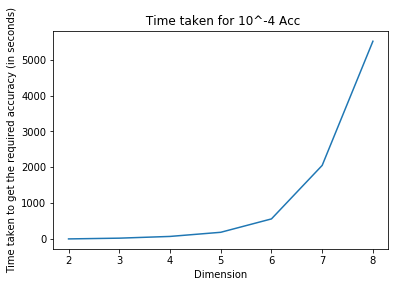

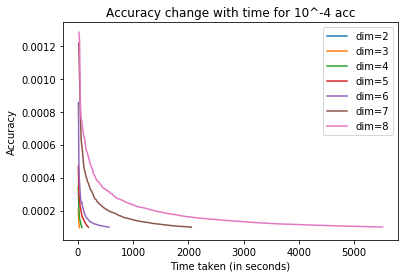

In [45]:
from matplotlib import pyplot as plt

plt.title(" Time taken for 10^-4 Acc")
plt.plot(list(range(2, config.maxNConteCarlo+1)),[x[-1] for x in timeElapseHA] );
plt.xlabel("Dimension")
plt.ylabel("Time taken to get the required accuracy (in seconds)")
plt.show()

plt.title("Accuracy change with time for 10^-4 acc")

for i in range(2, config.maxNConteCarlo+1):
    plt.plot(timeElapseHA[i-2],accArrHA[i-2]);

plt.xlabel("Time taken (in seconds)")
plt.ylabel("Accuracy")
plt.legend(['dim='+str(x) for x in list(range(2, config.maxNConteCarlo+1))])
plt.show()

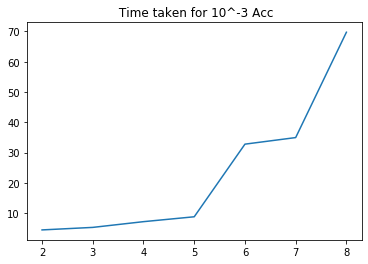

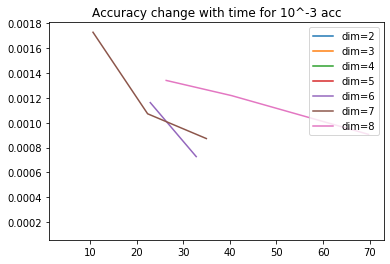

In [13]:
from matplotlib import pyplot as plt

plt.title(" Time taken for 10^-3 Acc")
plt.plot(list(range(2, config.maxNConteCarlo+1)),[x[-1] for x in timeElapseLA] 
plt.xlabel("Dimension")
plt.ylabel("Time taken to get the required accuracy (in seconds)")     
plt.show()

plt.title("Accuracy change with time for 10^-3 acc")

for i in range(2, config.maxNConteCarlo+1):
    plt.plot(timeElapseLA[i-2],accArrLA[i-2]);

plt.xlabel("Time taken (in seconds)")
plt.ylabel("Accuracy")         
plt.legend(['dim='+str(x) for x in list(range(2, config.maxNConteCarlo+1))])
plt.show()

A note on the above graph : We observe that the second graoh mostly contains straight lines and points. This can also be observed from the graph for $10^{-4}$ accuracy. The points here are too less and hence we see the curve like this.

In [48]:
for dim in range(2, config.maxNConteCarlo+1):
    print("Volume of hypersphere for dim in 4 digits precision with 95% confidence interval "+str(dim)," : ",meanArrHA[dim-2][-1] )

Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 2  :  3.1413326400000003
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 3  :  4.188514538666666
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 4  :  4.934750982564102
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 5  :  5.26394423908046
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 6  :  5.167404927999999
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 7  :  4.724776489195403
Volume of hypersphere for dim in 4 digits precision with 95% confidence interval 8  :  4.058653682512664


#### We see that these are very close to values found in wikipedia for the answers

In [20]:
arrK=[]
arrMean=[]
arrAcc=[]

for dim in range(2, config.maxNConteCarlo+1):
    k,mean,acc = cubeBasedIntegration(dim,1/10000, config.cubeIntegrationMaxSeconds)
    arrK.append(k)
    arrMean.append(mean)
    arrAcc.append(acc)

2 2 2.0 2.0
4 2 2.5 1.2
8 2 2.875 0.6086956521739131
16 2 3.03125 0.30927835051546393
32 2 3.1015625 0.1561712846347607
64 2 3.130859375 0.07860262008733625
128 2 3.13720703125 0.03953307392996109
256 2 3.1390380859375 0.01983278242271048
512 2 3.141143798828125 0.009929174479495574
1024 2 3.1412887573242188 0.004969215636270902
2048 2 3.1414928436279297 0.0024856607006357436
2 3 4.0 2.0
4 3 4.5 1.5555555555555556
8 3 4.25 1.0
16 3 4.1953125 0.5400372439478585
32 3 4.1904296875 0.27732463295269166
64 3 4.1884765625 0.14012590347400328
128 3 4.1896514892578125 0.0701962683876419
2 4 8.0 2.0
4 4 8.5 1.7647058823529411
8 4 6.03125 1.3367875647668395
16 4 5.208984375 0.7941507311586051
32 4 5.0120849609375 0.4165225650892618
2 5 16.0 2.0
4 5 15.5 2.0
8 5 8.25 1.6136363636363635
16 5 6.0263671875 1.0413223140495869
2 6 32.0 2.0
4 6 28.5 2.0
8 6 10.6328125 1.8589272593681117
2 7 64.0 2.0
4 7 49.5 2.0
8 7 13.4921875 1.9177764910248987
2 8 128.0 2.0
4 8 81.5 2.0


In [57]:
for dim in range(2, config.maxNConteCarlo+1):
    print("Volume of hypersphere in cubeBasedIntegration computed in given time: "+str(dim)," : ",arrMean[dim-2] )

Volume of hypersphere in cubeBasedIntegration computed in given time: 2  :  3.1414928436279297
Volume of hypersphere in cubeBasedIntegration computed in given time: 3  :  4.1896514892578125
Volume of hypersphere in cubeBasedIntegration computed in given time: 4  :  5.0120849609375
Volume of hypersphere in cubeBasedIntegration computed in given time: 5  :  6.0263671875
Volume of hypersphere in cubeBasedIntegration computed in given time: 6  :  10.6328125
Volume of hypersphere in cubeBasedIntegration computed in given time: 7  :  13.4921875
Volume of hypersphere in cubeBasedIntegration computed in given time: 8  :  81.5


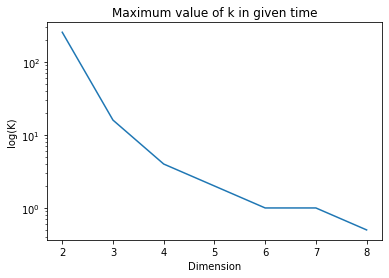

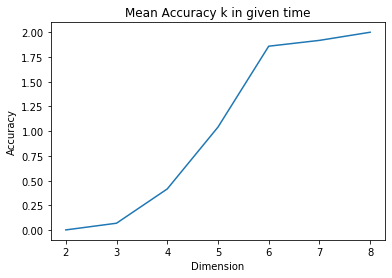

In [53]:
from matplotlib import pyplot as plt
arrK = np.asarray(arrK)/2
plt.title("Maximum value of k in given time")
plt.semilogy(list(range(2, config.maxNConteCarlo+1)),arrK );
plt.xlabel("Dimension")
plt.ylabel("log(K)")
plt.show()


plt.title("Mean Accuracy k in given time")
plt.plot(list(range(2, config.maxNConteCarlo+1)),arrAcc );
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.show()

We observe that the better method here is monteCarlo since the cube based integration method does not scale.    

We compare the runtimes of $10^{-3}$ and $10^{-4}$ accuracy and see that runtime would not scale for higher dimensions for $10^{-8}$ accuracy.   
In the second graph of how accuracy changes with time for higher dimension, we see that the rate of change becomes very less by the time it reaches $10^{-4}$ accuracy.


## Part 2: Comparing values of cubeBased and monteCarlo for $10^6$ points

In [54]:
"""
Naive implementation of Monte Carlo
"""

def monteCarloBare(n, dim, m=50):
    k  = n/m
    dist = np.zeros(m)
    cubeVolume = 2**dim
    for i in range(m):
        points = getPoints((int(k),dim))
        s = np.count_nonzero(np.sum( np.multiply(points,points), axis =1)<=1.0)
        dist[i]= s*cubeVolume/k
    return clt(dist)

In [ ]:
n = 1000000
monteCarloMean=[]
monteCarloAcc=[]
cubeBasedMean=[]
cubeBasedAcc=[]


for i in range(2,config.part2maxDim+1):
    mean,acc = monteCarloBare(n,i)
    monteCarloMean.append(mean)
    monteCarloAcc.append(acc)
    
    mean,acc = cubeBasedIntegrationForK(n**(1/i),i,timeit.default_timer()+ 10*config.cubeIntegrationMaxSeconds)
    cubeBasedMean.append(mean)
    cubeBasedAcc.append(acc)

    

In [24]:
print("monteCarloMean:",monteCarloMean)
print("monteCarloAcc:",monteCarloAcc)
print("cubeBasedMean:",cubeBasedMean)
print("cubeBasedAcc:",cubeBasedAcc)

monteCarloMean: [3.1400639999999997, 4.195016, 4.951232, 5.281663999999999, 5.180928, 4.715776, 4.061184]
monteCarloAcc: [0.0010477069624190496, 0.0016430031500015404, 0.0031215999298879636, 0.005041125725453177, 0.00734844285146019, 0.010427511505036185, 0.014899978828768328]
cubeBasedMean: [3.141312, 4.187856000000004, 5.010319999999999, 5.923743999999997, 7.88892800000001, 13.949184000000008, 27.67999999999998]
cubeBasedAcc: [0.005088319784854226, 0.08973756499745927, 0.42347155471107634, 1.0691724693031974, 1.6960682110421086, 1.9505221237313952, 1.9981317919075146]


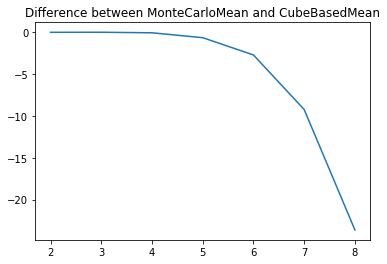

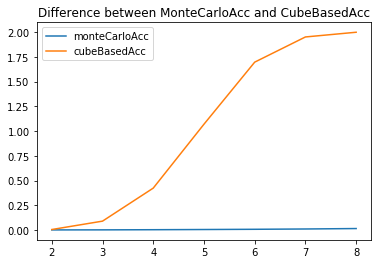

In [25]:
from matplotlib import pyplot as plt

plt.title("Difference between MonteCarloMean and CubeBasedMean")
plt.plot(list(range(2, config.part2maxDim+1)),np.asarray(monteCarloMean)-np.asarray(cubeBasedMean) );
plt.show()


plt.title("Difference between MonteCarloAcc and CubeBasedAcc")
plt.plot(list(range(2, config.part2maxDim+1)),monteCarloAcc );
plt.plot(list(range(2, config.part2maxDim+1)),cubeBasedAcc );
plt.legend(['monteCarloAcc','cubeBasedAcc'])


plt.show()

Monte Carlo Method is definitely giving us better answers here.     
we are taking mean of vPartial and Vinside to calculate voume(where vPartial contains points partly inside the sphere as well as the points fully inside it).Thus we are assuming that half of the partial points are inside the sphere.
A better approach would probably be weighted average where depending on the number of points inside the cube, we decide how much of cube is inside the sphere. 

### Part 3 : Calculating $\pi$ for $10^9$ points

In [40]:
pie,acc = monteCarloBare(10**9,2,70)

In [41]:
print(pie,acc)

3.141621764 2.9513388614575666e-05


### Antithetic distribution method
 the method of antithetic random variable utilizes symmetrical characteristic of
symmetry distribution. Here we will generate 4 identical distribution for calculatio of $\pi$

Consider $\frac{1}{4}th$ part of the circle with x,y $\in$ (0,1).
From this part, area of the circle = $\frac{\pi}{4}$. Area of the square surrounding it = 1.
Thus we can estimate the value of $\pi$ from this setup using Monte Carlo.   

Now Consider three other distributions between ((0,1),(0,-1)),((0,-1),(0,-1)),((0,-1),(0,1))
Since the unit sphere is symmetrical in all four axis, All of the four distributions will give identical results. Thus all the datapoints can be assumed to be observed four times.

This would help us in reducing variance.

Not that we are currently only experimenting with high and low of uniform distribution


In [42]:
def getPointsAntithetic(shape):
    return np.random.uniform(low=0.0,high =1.0,size=shape)

In [43]:
def monteCarloAntithetic(n, dim, m=50):
    k  = n/m
    dist = np.zeros(m)
    cubeVolume = 1.0
    for i in range(m):
        points = getPointsAntithetic((int(k),dim))
        s = np.count_nonzero(np.sum( np.multiply(points,points), axis =1)<=1.0)
        dist[i]= s*cubeVolume/k
    dist = np.hstack((dist, dist))
    dist = np.hstack((dist, dist))
    return clt(dist)

In [49]:
pieby4,acc = monteCarloAntithetic(10**9,2,70)
print(pieby4*4,acc)

3.1415269479999997 1.5822513240115787e-05


We observe that accuracy has improve by a factor of 2 on using antithetic variables.